# Water flow in soil (no root uptake) 

*by Daniel Leitner, Andrea Schnepf*


Water flow in soil is described by the Richards equation 
\begin{eqnarray} \label{eq:rich1d}
\frac{\partial \theta}{\partial t}= \frac{\partial}{\partial z}  \left[ K_c(\theta) \left( \frac{\partial h}{\partial z} -1 \right) \right],
\end{eqnarray}
where $\theta$ is the water content [1], $K_c$ is the hydraulic conductivity [m s$^{-1}$], $h$ is the pressure head [m]. 

## 1D

In one dimension benchmarks for water movment in soil were developed by Vanderborght et al. (2005). In the following we will shortly describe the benchmarks and implement their analytical solutions in the notebook. The analytical solutions are derived in Vanderborght et al. (2005).  

In the following benchmarks soil properties are described by the van Genuchten model (Van Genuchten, 1980). In the following we first import libraries and define some auxiliary functions:

In [16]:
import numpy as np
from scipy import optimize
from scipy import integrate
import matplotlib.pyplot as plt
from math import * 

In [17]:
# Mualem - van Genuchten model, equations from van Genuchten, MT (1980)

# class containing the van genuchten parameters
class Parameters:
    def __init__(self, R, S, alpha, n, Ksat):
        self.theta_R = R
        self.theta_S = S        
        self.alpha = alpha # [1/cm]         
        self.n = n
        self.m = 1.-1./n
        self.Ksat = Ksat       

# returns the volumetric water content at a given pressure head  according to the van genuchten model (Eqn 21)
def water_content(h, sp):
    return sp.theta_R + (sp.theta_S-sp.theta_R)/pow(1. + pow(sp.alpha*abs(h),sp.n),sp.m)

# returns pressure head at a given volumetric water content according to the van genuchten model
def pressure_head(theta, sp): 
    theta = min(theta,sp.theta_S) # saturated water conent is the maximum 
    return - pow( pow( (sp.theta_S - sp.theta_R)/(theta - sp.theta_R), (1./sp.m))-1., 1./sp.n) / sp.alpha

# returns the effective saturation according to the van genuchten model (dimensionless water content, Eqn 2)
def effective_saturation(h,sp):
    h = min(h,0) # pressure head is negative, zero the maximum
    theta = water_content(h,sp)
    se = (theta-sp.theta_R)/(sp.theta_S-sp.theta_R)
    return se

# returns the hydraulic conductivity according to the van genuchten model (Eqn 8)
def hydraulic_conductivity(h,sp):
    se = effective_saturation(h,sp) 
    K = sp.Ksat*sqrt(se)*( (1. - pow(1. - pow(se, 1. / sp.m),sp.m)) ** 2 )
    return K 

# returns the specific moisture storage according to the van genuchten model
def specific_moisture_storage(h,sp):
    C = -sp.alpha*sp.n*np.sign(h)*(1. / sp.n - 1.) * pow(sp.alpha*abs(h), sp.n-1.) * (sp.theta_R-sp.theta_S) * pow(pow(sp.alpha*abs(h),sp.n) + 1., 1./sp.n-2.)
    return C

# returns the water diffusivity (Eqn 11]
def water_diffusivity(TH,theta_i,theta_sur, sp):
    theta=TH*(theta_i-theta_sur) + theta_sur
    Se = (theta-sp.theta_R)/(sp.theta_S-sp.theta_R)
    m = sp.m
    D=(1-m)*sp.Ksat/(sp.alpha*m*(sp.theta_S-sp.theta_R)) * pow(Se,0.5-1./m) * (pow(1-pow(Se,1./m),-m) + pow(1-pow(Se,1/m),m)-2)
    #D = ((1-m)*sp.Ksat)/(sp.alpha*m*(sp.theta_S-sp.theta_R)) * pow(theta, 0.5-1./m)* (pow(1-pow(theta,1./m),-m) +pow(1-pow(theta,1./m),m) - 2)
    return D

The benchmarks use the following soil types (from the soil catalogue of Hydrus 1D), the parameters are $\theta_r$, $\theta_s$, $\alpha$, $n$, and $K_s$:

In [18]:
sand = Parameters(0.045, 0.43, 0.15, 3, 1000) 
loam = Parameters(0.08, 0.43, 0.04, 1.6, 50)
clay = Parameters(0.1, 0.4, 0.01, 1.1, 10)

### Benchmark 1: Steady state flux in a layered soil profile


*Soil*: 

Two layers: 0-50 cm, and 50-200 cm  Three scenarios: loam over sand, sand over loam, clay over sand 

*Initial condition*: 

-200 cm in both layers. 

*Boundary conditions*: 

Influx of 0.5 cm d$^{-1}$ at top and free drainage at the bottom


The analytical solution of Benchmark 1 is calculated by the following code and reproduces Figure 2abc from Vanderborght et al. (2005). 

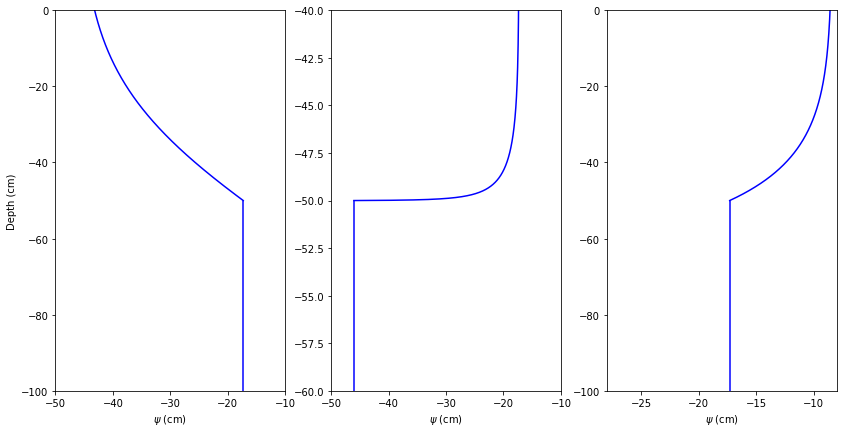

In [19]:
Jw = 0.5;  # constant downward flow rate [cm/d]

# The lower part (constant pressure)
Ks = lambda psi: hydraulic_conductivity(psi,sand)-Jw
Kl = lambda psi: hydraulic_conductivity(psi,loam)-Jw
Kc = lambda psi: hydraulic_conductivity(psi,clay)-Jw
psi_s = optimize.brentq(Ks, -100, 0);
psi_l = optimize.brentq(Kl, -100, 0);
psi_c = optimize.brentq(Kc, -100, 0);

# The upper part
Ks = lambda psi: hydraulic_conductivity(psi,sand)
Kl = lambda psi: hydraulic_conductivity(psi,loam)
Kc = lambda psi: hydraulic_conductivity(psi,clay)
Fs = lambda psi: 1./(Jw/Ks(psi) - 1.) # integrand Eqn [14]
Fl = lambda psi: 1./(Jw/Kl(psi) - 1.)
Fc = lambda psi: 1./(Jw/Kc(psi) - 1.)
    
N = 1000 # resolution
dz = np.ones(N,)
eps = 1.e-5 # to avoid quadrature warnings
    
psiA = np.linspace(psi_l+eps,psi_s,N) # loam (on sand)
for i in range(0,N):
    ans, err = integrate.quad(Fl,psi_s, psiA[i])
    dz[i] = ans
zA = dz - 50. 
     
psiB = np.linspace(psi_l,psi_s-eps,N) # sand (on loam)
for  i in range(0,N):
    ans, err = integrate.quad(Fs,psi_l,psiB[i])
    dz[i] = ans
zB = dz + -50;
         
psiC = np.linspace(psi_s,psi_c-eps,N); # clay (on sand)
for  i in range(0,N):    
    ans, err = integrate.quad(Fc,psi_s,psiC[i])
    dz[i] = ans    
zC = dz + (-50);
        
# prepare plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 7))    
z_ = np.linspace(-50,-100,2)
ax1.plot([psi_s,psi_s],z_,'b') 
ax1.plot(psiA,zA,'b');
ax1.set_xlabel('$\psi$ (cm)')
ax1.set_ylabel('Depth (cm)')
ax1. set_xlim(-50,-10)
ax1.set_ylim(-100,0)    
ax2.plot([psi_l,psi_l],z_,'b')
ax2.plot(psiB,zB,'b');
ax2.set_xlabel('$\psi$ (cm)')
ax2.set_xlim(-50,-10)
ax2.set_ylim(-60,-40)    
ax3.plot([psi_s,psi_s],z_,'b') 
ax3.plot(psiC,zC,'b');
ax3.set_xlabel('$\psi$ (cm)')
ax3.set_xlim(-28,-8)
ax3.set_ylim(-100,0)
plt.show()

### Benchmark 2: Steady state evaporation from a water table


*Soil*: 

loamy soil profile 0-45 cm 

*Initial condition*: 

$\psi(z,t=0) = z - 54$ cm 

*Boundary conditions*: 

Eflux of 0.5 cm d$^{-1}$ at top and full saturation at the bottom 


The analytical solution of Benchmark 2 is calculated by the following code and reproduces Figure 3 from Vanderborght et al. (2005). 

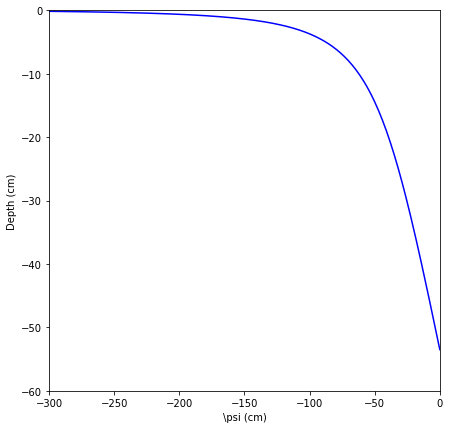

In [20]:
Jw = -0.5 # cm/day

K = lambda psi: hydraulic_conductivity(psi,loam)
F = lambda psi: 1./(Jw/K(psi) - 1.)

psi_ = np.linspace(0,-300,300) # psi(-54) = 0
dz = np.zeros(len(psi_),)
for i in range(0, len(psi_)):
    ans,err = integrate.quad(F,0,psi_[i])
    dz[i] = ans

z1 = dz + (-53.5)

fig=plt.figure(figsize=(7, 7))
plt.plot(psi_, z1,'b')
plt.xlabel('\psi (cm)')
plt.ylabel('Depth (cm)')
plt.xlim(-300,0)
plt.ylim(-60,0)
plt.show()

### Benchmark 3: Infiltration in an initially dry soil


*Soil*: 

Three scenarios: sand, loam, and clay, all 0-200 cm 

*Initial condition*: 

-400 cm 

*Boundary conditions*: 

At top an influx of 100 cm d$^{-1}$ if $\psi(z=0)< 0$ cm, else full saturation. At bottom free drainage.

The analytical solution of Benchmark 3 is calculated by the following code and reproduces Figure 4abc from Vanderborght et al. (2005). 

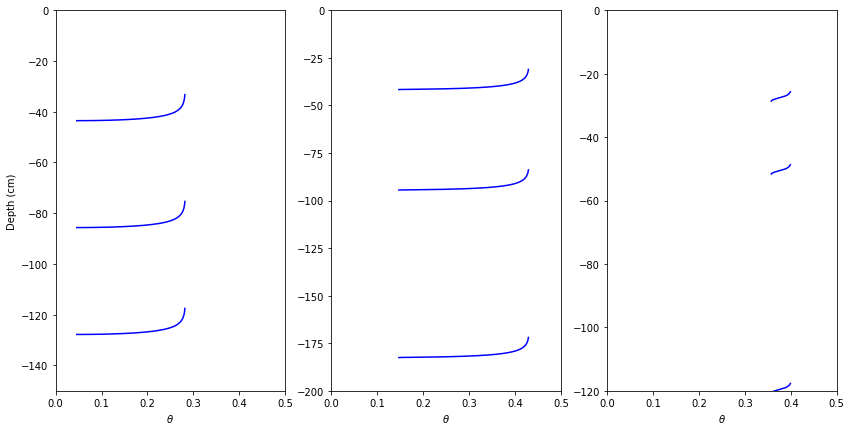

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 7))
ax = [ax1,ax2,ax3]

for i, soil in enumerate([sand, loam, clay]): # make three subplots
        
    if soil==sand:
        theta_sur = 0.2824 # ?
    else:
        theta_sur = soil.theta_S
            
    theta_i = water_content(-400,soil);
        
    K_sur = hydraulic_conductivity( pressure_head(theta_sur,soil), soil);
    K_i = hydraulic_conductivity(-400, soil)
    psi = lambda theta: pressure_head(theta,soil)
    K = lambda psi: hydraulic_conductivity(psi,soil)
    Dw = lambda psi: K(psi)/(specific_moisture_storage(psi,soil))            
    F = lambda theta:  Dw(psi(theta)) / ( (K_sur - K_i)*(theta - theta_i) - (K(psi(theta)) - K_i)*(theta_sur - theta_i) ) 
    
    theta_a = (theta_sur+theta_i)/2
    theta_ = np.linspace (theta_i+1e-3,theta_sur-1e-3,300)

    delta_eta = np.zeros(len(theta_),)
    for j in range(0,len(theta_)):
        ans, err = integrate.quad(F,theta_[j],theta_a)
        delta_eta[j] = ans
    
    delta_eta = delta_eta * (theta_sur - theta_i)
    
    tv=[ [0.1, 0.2, 0.3], [0.2, 0.5, 1.0], [0.1, 0.2, 0.5] ] # time values (days)

    x_aa = [43, 41, 27.5] # how to choose reference water content and its position ?
    x_a = x_aa[i]
    
    t_a2 = [0.1, 0.2, 0.1] 
    t_a = t_a2[i]
        
    eta_a = x_a - (K_sur-K_i)/(theta_sur - theta_i)*t_a
    eta = delta_eta + eta_a

    # finally, plot the thing    
    for j in range(0,len(tv[0])):
        t = tv[i][j]
        x = eta  + (K_sur - K_i) * t / (theta_sur - theta_i);
        ax[i].plot(theta_,-x,'b-')    
    ax[i].set_xlabel(r'$\theta$')
    ax[i].set_xlim(0,0.5)

ax1.set_ylabel('Depth (cm)')
ax1.set_ylim(-150,0)
ax2.set_ylim(-200,0)
ax3.set_ylim(-120,0)
plt.show()

### Benchmark 4: Transient evaporation from a soil profile


*Soil*: 

Four scenarios: sand, loam, loam, and clay, all 0-100 cm 

*Initial condition*: 

-200 cm 

*Boundary conditions*: 

At top an eflux of 0.3 cm d$^{-1}$ if $\psi(z=0)< -10000$ cm, else $\psi(z=0) = -10000$ cm.
No flux at the bottom.

The analytical solution of Benchmark 4 is calculated by the following code and reproduces Figure 5abcd from Vanderborght et al. (2005). 


Scenario  0  tpot 0.003753297475066294
Scenario  1  tpot 0.9674145845512362
Scenario  2  tpot 0.10749050939458182
Scenario  3  tpot 0.5805044649703122


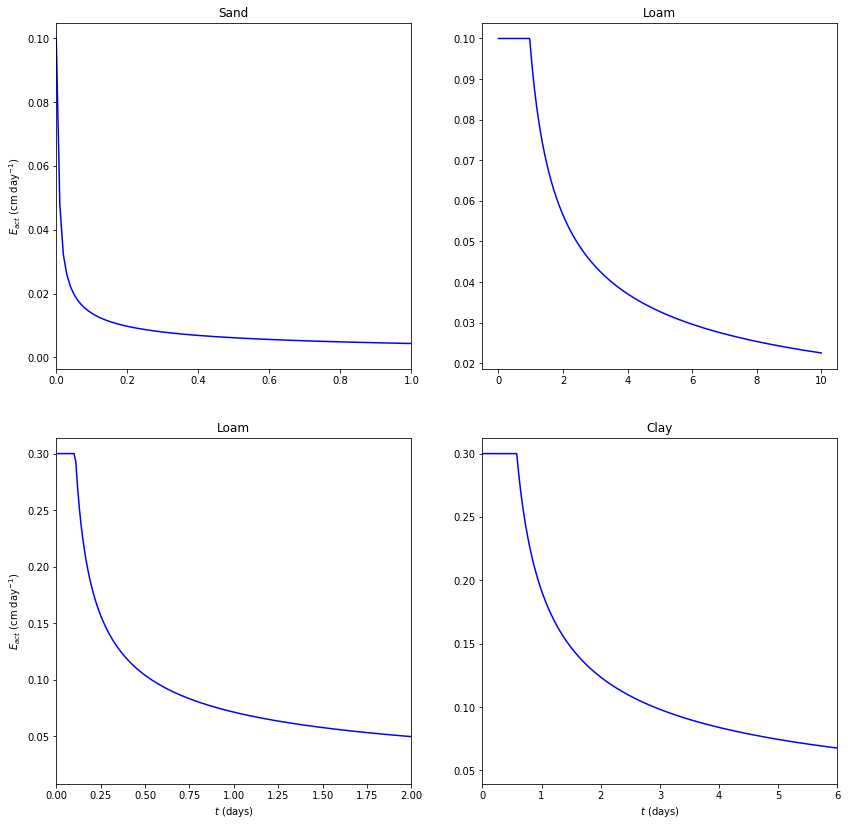

In [22]:
jwpot_ = [-0.1, -0.1, -0.3, -0.3]
head_i_ = [-40,-200,-200,-200]

N = 1000
y = np.zeros((N,4))
t = np.linspace(0,10,N) # days

for i,soil in enumerate([sand, loam, loam, clay]):
    head_i = head_i_[i]
    theta_i = water_content(head_i,soil) # initial theta  
    theta_sur = water_content(-10000,soil) # critical vaule 
    jwpot = jwpot_[i]   
    
    #TH = (theta-theta_sur)/(theta_i-theta_sur)
    dw = lambda TH: water_diffusivity(TH,theta_i, theta_sur, soil)    
    int_dw, err = integrate.quad(dw,0,1)    

    theta_dw = lambda TH: TH*water_diffusivity(TH,theta_i, theta_sur, soil)       
    int_theta_dw, err = integrate.quad(theta_dw,0,1)
    beta = pow(int_theta_dw/int_dw,2) # 43

    fun_dw = lambda TH: pow(1-TH*beta,2)*dw(TH)
    alpha, err = integrate.quad(fun_dw,0,1)
    alpha /= int_dw # 42

    mu = ( 3*beta*(1+sqrt(1-(14/9)*(1-alpha/pow(1-beta,2)) ) ) ) / ( 2*(1-beta)*(alpha/pow(1-beta,2)-1) ) # eq 41

    sw = lambda theta_sur, theta_i: (theta_i-theta_sur)*sqrt((4/mu)*int_dw) # eq 39
  
    tdash = (sw(theta_sur, theta_i)*sw(theta_sur, theta_i)) / (4*jwpot*jwpot) # eq 44
    tpot =  (sw(theta_sur, theta_i)*sw(theta_sur, theta_i)) / (2*jwpot*jwpot) # eq 45
    print("Scenario ", i, " tpot", tpot)
    
    jw = lambda t: (t<tpot)*jwpot+(t>=tpot)*sw(theta_sur, theta_i)/(2*sqrt(abs(tdash+t-tpot))) # eq 46 & 47

    y[:,i] = list(map(jw,t))  # evaluate

#
# prepare plot
#
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 14))
    
ax1.plot(t,abs(y[:,0]),'b')
ax1.set_ylabel('$E_{act}$ (cm day$^{-1}$)')
ax1.set_xlim(0,1)
ax1.set_title("Sand")

ax2.plot(t,abs(y[:,1]),'b')
#ax2.set_xlim(0,10)
ax2.set_title("Loam")

ax3.plot(t,abs(y[:,2]),'b')
ax3.set_xlabel('$t$ (days)')
ax3.set_ylabel('$E_{act}$ (cm day$^{-1}$)')
ax3.set_xlim(0,2)
ax3.set_title("Loam")

ax4.plot(t,abs(y[:,3]),'b')
ax4.set_xlabel('$t$ (days)')
ax4.set_xlim(0,6)
ax4.set_title("Clay")
plt.show()

## 3D

Suitable benchmarks could be discussed or developed at the workshop

## Discussion

There are many softwares solving Richards equation. What are the most important features, and which softwares are most suitable for a specific purpose. 

* Availability and license 
* Dimensions: 1D, 1D axial symmetric, 3D
* Mass conservation
* Parallel computing
* Support of unstructured meshes and adaptive refinement

## Comparison to numerical solutions

Benchmark 1-4 was evaluated for *Macro*, *Hydrus1D*, *Swap*, *Marthe*, and *Wave* in Vanderborght et al. 2005. 

We plan to validate additional numerical codes by solving the benchmarking problems 1-4 and the ones we will develop for 3D. In the following we link to notebooks, containing all or some of above benchmarks: 

* [Dumux](Soil water flow - Dumux.ipynb)


## References

Vanderborght, J and Kasteel, R and Herbst, M and Javaux, M and Thiery, D and Vanclooster, M and Mouvet, C and Vereecken, H (2005) A set of analytical benchmarks to test numerical models of flow and transport in soils. *Vadose Zone Journal*, 4(1):206-221

Van Genuchten, MT (1980) Closed-form equation for predicting the hydraulic conductivity of unsaturated soils. *Soil Science Society of America Journal* 44(5):892-898
